# HOMan Demo Notebook

Demo notebook for "Towards reconstructing unconstrained hand-object interactions", Yana Hasson, Gül Varol, Ivan Laptev, Cordelia Schmid

Project webpage: [https://hassony2.github.io/homan.html](https://hassony2.github.io/homan.html)

Github repo: [https://github.com/hassony2/homan](https://github.com/hassony2/homan)

**HOMan** stands for Hand-Object MANipulation.

## Instructions

This notebook provides a step by step guide to perform the following:

- A. Enable GPU (Runtime > Change Runtime Type > GPU)
- B. Get HOMan code
- C. Install dependencies
  - Python packages
  - Install SMPL-X, MANO, NMR, detectron2, FrankMocap
- D. Run HOMan!
  - Download images
  - Load image and object model
  - Joint hands and object pose estimation


*Notes*:
- Given that several libraries need to be compiled, running the whole notebook takes some time, roughly 15 minutes in total.
- Some videos might not show if you are not using Google Chrome as a browser

# A. Enable GPU

Go to Runtime > Change Runtime Type > GPU


# B.  Get HOMan code

Clone the github repository by running the cell below.

### Install Python dependencies


### Install SMPL-X, MANO, NMR, detectron2, FrankMocap

- Download SMPL-X data locally
  - Create an account on the [smpl-x website](https://smpl-x.is.tue.mpg.de/en/sign_up) and accept the license
  - Head to the [download page](https://smpl-x.is.tue.mpg.de/downloads)
  - Click the "Download SMPL-X V1.1" button and save to your computer

*Side note*: There are [several ways](https://www.roelpeters.be/how-to-uploading-files-in-google-colab/) you can upload data so that it is available in colab, here I will walk you through one way to do it, but feel free to explore [other options](https://www.roelpeters.be/how-to-uploading-files-in-google-colab/).
For instance, if you plan on running this colab several times, consider uploading the files to a google drive and using gdown to download it, this will be faster and will allow you to rerun without manually re-uploading by hand every time !
- Upload SMPL-X model data to this colab
  - Run the cell below
  - Browse to the downloaded *models_smplx_v1_1.zip* file

- Unzip SMPL-X data model files to *extra_data/model*
(Simply run the cell below)

- Install [Neural Mesh Renderer](https://github.com/daniilidis-group/neural_renderer) (NMR) (I slightly modified the fast PyTorch version from [Wen Jiang](https://github.com/JiangWenPL/multiperson/tree/master/neural_renderer) to make the package compatible with pytorch >= 1.6 :) )

Note that this step takes some time !

- Download MANO using data from [GrabNet](https://https://github.com/otaheri/GrabNet), Taheri et al., ECCV 2020

!gdown "https://drive.google.com/uc?id=1L_We51j5FwIo5PeLvAK_9I3ZuFU_IWAq"
# clone the repo
!unzip grabnet_data.zip
!rm grabnet_data.zip
!mkdir -p extra_data/mano/
!mv grabnet_data/MANO_RIGHT.pkl extra_data/mano/

# Create MANO_LEFT.pkl from MANO_RIGHT.pkl
from homan import manoconv
_ = manoconv.left_from_right("extra_data/mano/MANO_RIGHT.pkl", "extra_data/mano/MANO_LEFT.pkl")

- Install [detectron2](https://github.com/facebookresearch/detectron2)

- Install [FrankMocap](https://github.com/facebookresearch/frankmocap/) (Slightly modified version to return the object bounding boxes along with the hand detections)

- Fix pycocotools error using most recent install.


# D. Run HOMan !

## Get HOMan inputs

### Download hand-object manipulation images

- Download a sequence of images representing of hand-object interactions
- Put the sequence in the `images` folder
- The images will be loaded **alphabetically** sorted according to their file names

### Load and display the manipulation images

Load images as numpy array.

In [11]:
%load_ext autoreload
%autoreload 2

['images/C_01_16_160.png', 'images/C_01_16_161.png', 'images/C_01_16_162.png', 'images/C_01_16_163.png', 'images/C_01_16_164.png', 'images/C_01_16_165.png', 'images/C_01_16_166.png', 'images/C_01_16_167.png', 'images/C_01_16_168.png', 'images/C_01_16_169.png']
Loaded 10 images, displaying the first 10


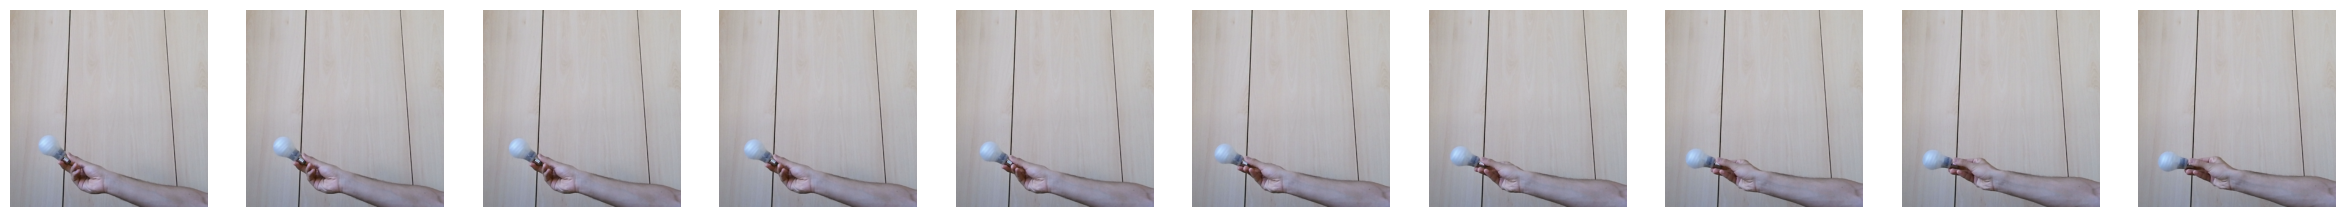

In [12]:
import os
import os.path as osp
import numpy as np
from PIL import Image

from libyana.visutils import imagify

# Get images in "images" folder according to alphabetical order
image_folder = "images"
image_names = sorted(os.listdir(image_folder))
start_idx = 160
if start_idx >= len(image_names) - 10:
  start_idx = len(image_names) - 11
image_paths = [os.path.join(image_folder, image_name) for image_name in image_names[start_idx:start_idx + 10]]
print(image_paths)

# Convert images to numpy
images = [Image.open(image_path) for image_path in image_paths if (image_path.lower().endswith(".jpg") or image_path.lower().endswith(".png"))]
images_np = [np.array(image) for image in images]


# Visualize the 10 frames
viz_num_images = 10
print(f"Loaded {len(images)} images, displaying the first {viz_num_images}")
imagify.viz_imgrow(images_np[:viz_num_images], path='results/tmp.png')


### Get approximate or exact object CAD model

Our method takes an approximate or exact object model as input, along with an approximate object scale in world metric space *obj_scale*.

Two projections of the centered object vertices, scaled to 8.0 cm


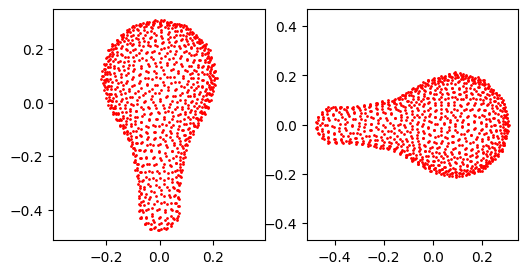

In [13]:
import trimesh

# Get local object model
obj_path = "local_data/datasets/shapenetmodels/206ef4c97f50caa4a570c6c691c987a8.obj"


# Initialize object scale
obj_scale = 0.08  # Obj dimension in meters (0.1 => 10cm, 0.01 => 1cm)

obj_mesh = trimesh.load(obj_path, force="mesh")
obj_verts = np.array(obj_mesh.vertices).astype(np.float32)

# Center and scale vertices
obj_verts = obj_verts - obj_verts.mean(0)
obj_verts_can = obj_verts / np.linalg.norm(obj_verts, 2, 1).max() * obj_scale / 2
obj_faces = np.array(obj_mesh.faces)

# Display object vertices as scatter plot to visualize object shape
print(f"Two projections of the centered object vertices, scaled to {obj_scale * 100} cm")
imagify.viz_pointsrow([obj_verts, obj_verts[:, 1:]], path='results/tmp.png')

## Joint hands and object pose estimation

Run our method !

### Step 0: Detect and track the hands and objects

We detect the hand and manipulated object using the pre-trained detector from [Understanding Human Hands in Contact at Internet Scale](https://fouheylab.eecs.umich.edu/~dandans/projects/100DOH/), Shan et al., CVPR 2020 in each frame independently.

We perform tracking using Kalman filtering using the [motpy](https://github.com/wmuron/motpy) library, mostly to interpolate missing detections.

None
Loading Body Pose Estimator
Loading Ego Centric Hand Detector


frame: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


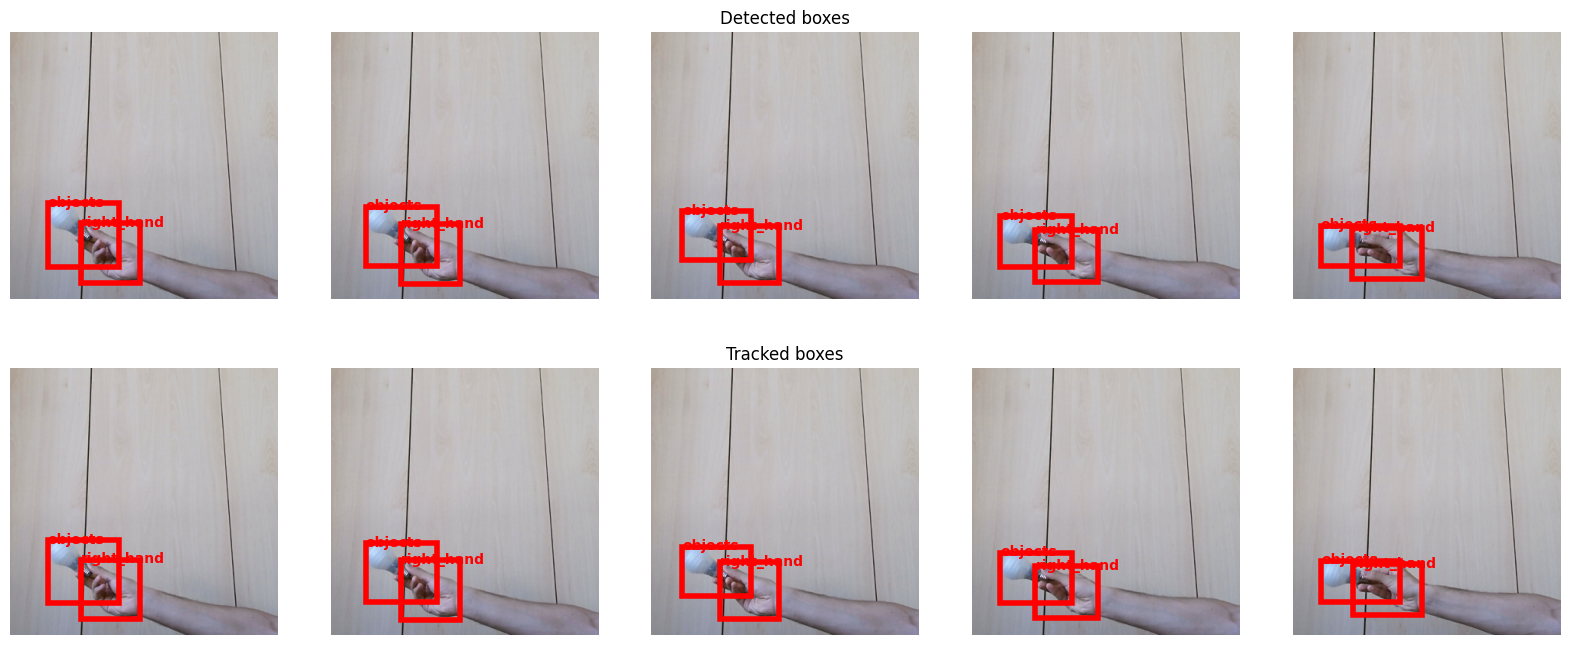

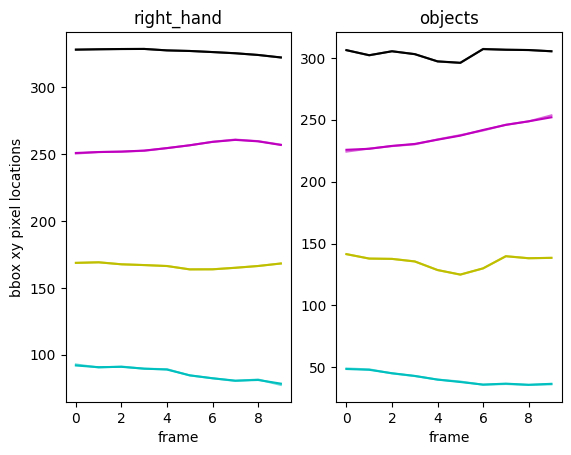

In [14]:
import os
import sys
sys.path.insert(0, "external/frankmocap/detectors/hand_object_detector/lib")
sys.path.insert(0, "external/frankmocap")


import numpy as np
from PIL import Image

from handmocap.hand_bbox_detector import HandBboxDetector

from homan.tracking import trackseq
from homan.mocap import get_hand_bbox_detector
from homan.utils.bbox import  make_bbox_square, bbox_xy_to_wh

# Load object mesh
hand_detector = get_hand_bbox_detector()
seq_boxes = trackseq.track_sequence(images, 256, hand_detector=hand_detector, setup={"right_hand": 1, "objects": 1})
hand_bboxes = {key: make_bbox_square(bbox_xy_to_wh(val), bbox_expansion=0.1) for key, val in seq_boxes.items() if 'hand' in key}
obj_bboxes = [seq_boxes['objects']]

### Step 1: Compute 2D masks and 3D hand pose initializations

- **2D** hand and object masks are extracted using [PointRend](https://github.com/facebookresearch/detectron2/tree/master/projects/PointRend), Kirillov et al., CVPR 2020
- **3D** and poses are initialized using [FrankMocap](https://github.com/facebookresearch/frankmocap), Rong et al, 2020.



ValueError: Could not save to JPEG for display

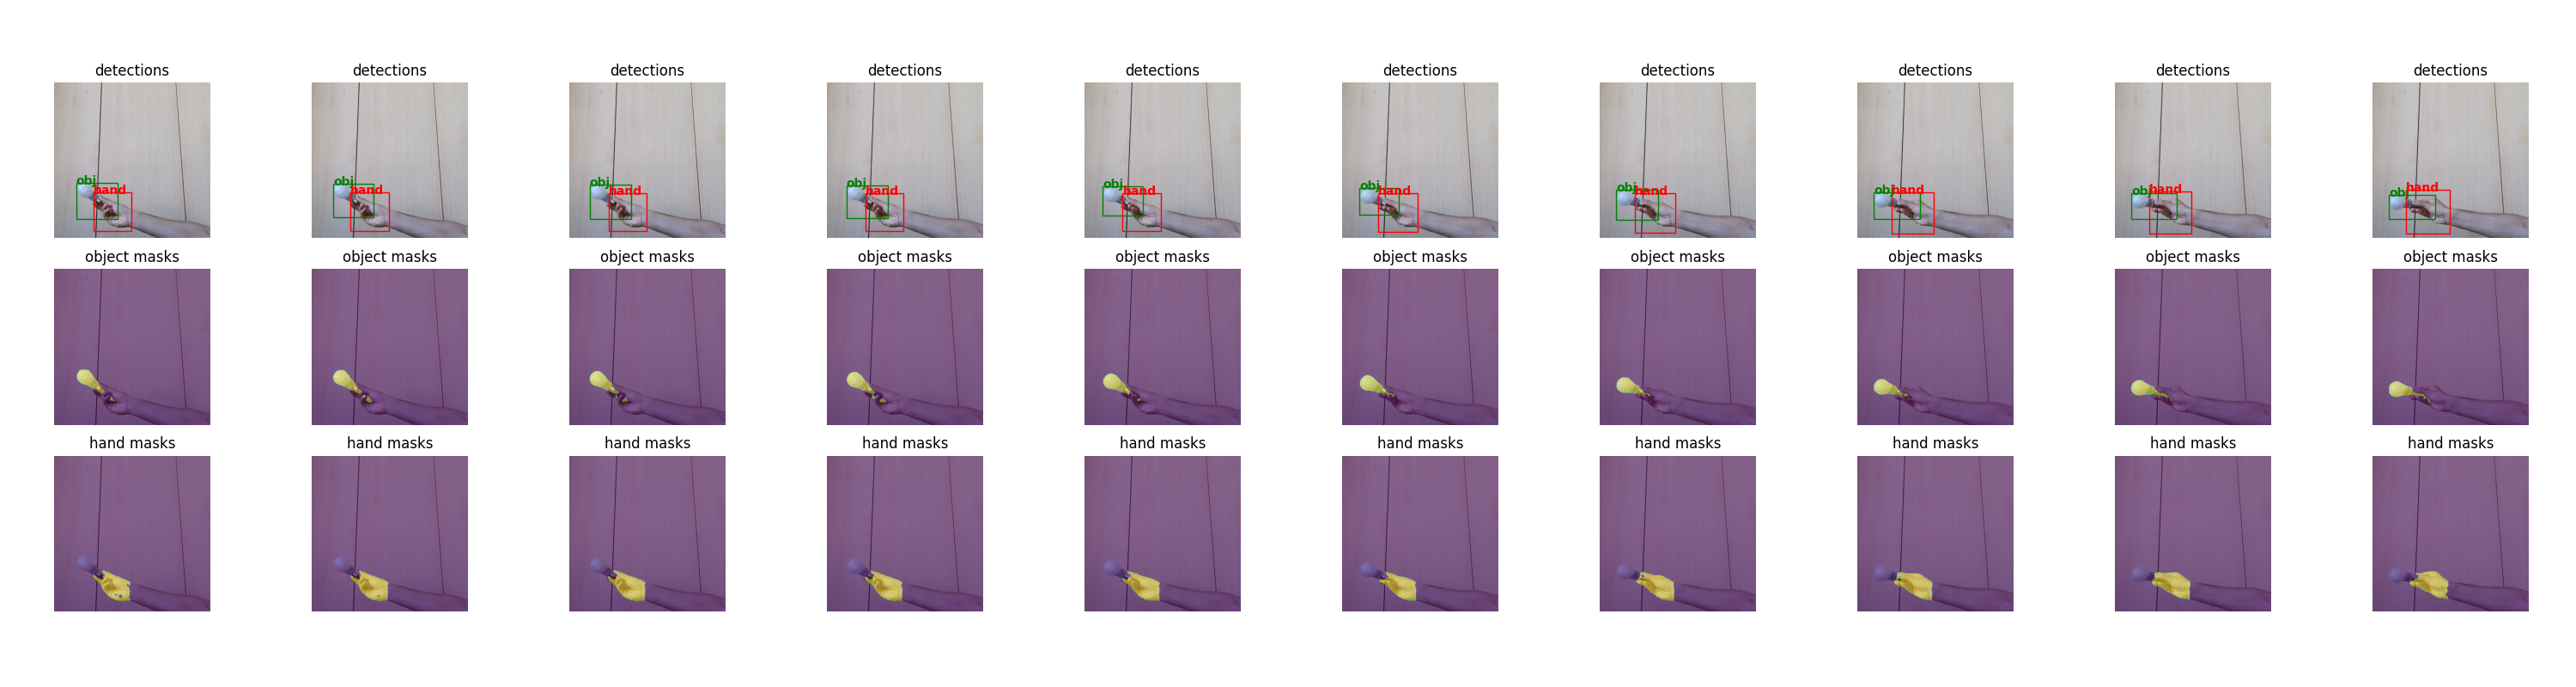

In [15]:
from homan.prepare.frameinfos import get_frame_infos
from homan.pointrend import MaskExtractor
from handmocap.hand_mocap_api import HandMocap
sample_folder = "tmp/"

# Initialize segmentation and hand pose estimation models
mask_extractor = MaskExtractor(pointrend_model_weights="detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl")
frankmocap_hand_checkpoint = "extra_data/hand_module/pretrained_weights/pose_shape_best.pth"
hand_predictor = HandMocap(frankmocap_hand_checkpoint, "extra_data/smpl")

# Define camera parameters
height, width, _ = images_np[0].shape
image_size = max(height, width)
focal = 480
camintr = np.array([[focal, 0, width // 2], [0, focal, height // 2], [0, 0, 1]]).astype(np.float32)
camintrs = [camintr for _ in range(len(images_np))]

# Initialize object motion
person_parameters, obj_mask_infos, super2d_imgs = get_frame_infos(images_np,
                                                                  mask_extractor=mask_extractor,
                                                                  hand_predictor=hand_predictor,
                                                                  hand_bboxes=hand_bboxes,
                                                                  obj_bboxes=np.stack(obj_bboxes),
                                                                  sample_folder=sample_folder,
                                                                  camintr=camintrs,
                                                                  image_size=image_size,
                                                                  debug=False)
Image.fromarray(super2d_imgs)

Note that the joint fitting relies heavily on the 2D evidence. The better it is, the better you can expect the final joint reconstruction to be !

## Step 1: Initialize object pose

Similarly to [PHOSA](https://github.com/facebookresearch/phosa/pulls) (Perceiving 3D Human-Object Spatial Arrangements from a Single Image in the Wild), Zhang et al., ECCV 2020, we use the 2D object mask to initialize the object pose using differentiable rendering.

We extract an object **motion initialization** by consecutively **fitting** the 3D object pose to the 2D evidence in each frame.

We use different `num_initializations` **random rotation initializations** to initialize the object rotation in the first frame.

We initialize the object pose in each subsequent frame by initializing the object pose using the rotation of the previous frame, resulting in consistent object pose initializations across frames.

This procedure results in `num_initializations` candidate object motion initializations.

We **select** the **best motion candidate** by keeping the poses which result in the best average IoU between the rendered object mask and the target PointRend mask.

In [16]:
from homan.pose_optimization import find_optimal_poses
from homan.lib2d import maskutils

object_parameters = find_optimal_poses(
    images=images_np,
    image_size=images_np[0].shape,
    vertices=obj_verts_can,
    faces=obj_faces,
    annotations=obj_mask_infos,
    num_initializations=200,
    num_iterations=10, # Increase to get more accurate initializations
    Ks=np.stack(camintrs),
    viz_path=os.path.join(sample_folder, "optimal_pose.png"),
    debug=False,
)

# Add object object occlusions to hand masks
for person_param, obj_param, camintr in zip(person_parameters,
                                        object_parameters,
                                        camintrs):
    maskutils.add_target_hand_occlusions(
        person_param,
        obj_param,
        camintr,
        debug=False,
        sample_folder=sample_folder)


  0%|          | 0/10 [00:00<?, ?it/s]

loss: 3.62e+03: 100%|██████████| 10/10 [00:00<00:00, 14.93it/s]


## Step 2: Coarse joint optimization

We **jointly** optimize the hand and object poses to fit the extracted hand and object evidence and coarse priors for **motion smoothness** and **hand-object proximity**.

In [17]:
from homan.viz.colabutils import display_video
from homan.jointopt import optimize_hand_object

coarse_num_iterations = 201 # Increase to give more steps to converge
coarse_viz_step = 10 # Decrease to visualize more optimization steps
coarse_loss_weights = {
        "lw_inter": 1,
        "lw_depth": 0,
        "lw_sil_obj": 1.0,
        "lw_sil_hand": 0.0,
        "lw_collision": 0.0,
        "lw_contact": 0.0,
        "lw_scale_hand": 0.001,
        "lw_scale_obj": 0.001,
        "lw_v2d_hand": 50,
        "lw_smooth_hand": 2000,
        "lw_smooth_obj": 2000,
        "lw_pca": 0.004,
    }

# Camera intrinsics in normalized coordinate
camintr_nc = np.stack(camintrs).copy().astype(np.float32)
camintr_nc[:, :2] = camintr_nc[:, :2] / image_size

step2_folder = os.path.join(sample_folder, "jointoptim_step2")
step2_viz_folder = os.path.join(step2_folder, "viz")

# Coarse hand-object fitting
model, loss_evolution, imgs = optimize_hand_object(
    person_parameters=person_parameters,
    object_parameters=object_parameters,
    hand_proj_mode="persp",
    objvertices=obj_verts_can,
    objfaces=np.stack([obj_faces for _ in range(len(images_np))]),
    optimize_mano=True,
    optimize_object_scale=True,
    loss_weights=coarse_loss_weights,
    image_size=image_size,
    num_iterations=coarse_num_iterations + 1,  # Increase to get more accurate initializations
    images=np.stack(images_np),
    camintr=camintr_nc,
    state_dict=None,
    viz_step=coarse_viz_step,
    viz_folder=step2_viz_folder,
)
print(f"{coarse_viz_step}, {step2_viz_folder}")
print(os.path.join(step2_folder, "joint_optim.mp4"))
print(os.path.join(sample_folder, "jointoptim_step2.mp4"))

last_viz_idx = (coarse_num_iterations // coarse_viz_step) * coarse_viz_step
video_step2 = display_video(os.path.join(step2_folder, "joint_optim.mp4"),
                            os.path.join(sample_folder, "jointoptim_step2.mp4"))
display(video_step2)

Loss 2.1256:   2%|▏         | 4/202 [00:00<00:10, 18.10it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000000.jpg.


Loss 1.4235:   6%|▋         | 13/202 [00:00<00:09, 20.12it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000010.jpg.


Loss 1.1241:  12%|█▏        | 25/202 [00:01<00:07, 23.93it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000020.jpg.


Loss 0.9122:  18%|█▊        | 36/202 [00:01<00:06, 25.17it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000030.jpg.


Loss 0.7563:  21%|██▏       | 43/202 [00:01<00:06, 23.16it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000040.jpg.


Loss 0.6227:  27%|██▋       | 55/202 [00:02<00:05, 25.12it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000050.jpg.


Loss 0.5075:  33%|███▎      | 66/202 [00:02<00:05, 25.54it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000060.jpg.


Loss 0.4098:  36%|███▌      | 73/202 [00:03<00:05, 23.41it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000070.jpg.


Loss 0.3301:  42%|████▏     | 85/202 [00:03<00:04, 25.33it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000080.jpg.


Loss 0.2658:  48%|████▊     | 96/202 [00:03<00:04, 25.70it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000090.jpg.


Loss 0.2149:  51%|█████     | 103/202 [00:04<00:04, 23.62it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000100.jpg.


Loss 0.1752:  57%|█████▋    | 115/202 [00:04<00:03, 25.21it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000110.jpg.


Loss 0.1446:  62%|██████▏   | 126/202 [00:05<00:02, 25.74it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000120.jpg.


Loss 0.1220:  66%|██████▌   | 133/202 [00:05<00:02, 23.66it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000130.jpg.


Loss 0.1050:  72%|███████▏  | 145/202 [00:05<00:02, 25.29it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000140.jpg.


Loss 0.0927:  77%|███████▋  | 156/202 [00:06<00:01, 25.86it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000150.jpg.


Loss 0.0831:  81%|████████  | 163/202 [00:06<00:01, 23.77it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000160.jpg.


Loss 0.0771:  87%|████████▋ | 175/202 [00:07<00:01, 26.07it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000170.jpg.


Loss 0.0725:  92%|█████████▏| 186/202 [00:07<00:00, 26.80it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000180.jpg.


Loss 0.0695:  96%|█████████▌| 194/202 [00:07<00:00, 25.22it/s]

Saved rendered image to tmp/jointoptim_step2/viz/00000190.jpg.


Loss 0.0682: 100%|██████████| 202/202 [00:08<00:00, 24.81it/s]


Saved rendered image to tmp/jointoptim_step2/viz/00000200.jpg.
MoviePy - Building file tmp/jointoptim_step2/viz/0000020024.gif with imageio.


Saved video to tmp/jointoptim_step2/viz/0000020024.gif
Moviepy - Building video tmp/jointoptim_step2/joint_optim.webm.
Moviepy - Writing video tmp/jointoptim_step2/joint_optim.webm



Moviepy - Done !
Moviepy - video ready tmp/jointoptim_step2/joint_optim.webm
Saved video to tmp/jointoptim_step2/joint_optim.webm
Moviepy - Building video tmp/jointoptim_step2/joint_optim.mp4.
Moviepy - Writing video tmp/jointoptim_step2/joint_optim.mp4



Moviepy - Done !
Moviepy - video ready tmp/jointoptim_step2/joint_optim.mp4
Saved video to tmp/jointoptim_step2/joint_optim.mp4
save to  tmp/jointoptim_step2/joint_optim.webm tmp/jointoptim_step2/viz/0000020024.gif
10, tmp/jointoptim_step2/viz
tmp/jointoptim_step2/joint_optim.mp4
tmp/jointoptim_step2.mp4


In [ ]:
from homan.viz.colabutils import display_video
print(f"from {osp.join(step2_folder, 'joint_optim.mp4')} to {osp.join(sample_folder, 'jointoptim_step2.mp4')}")
video_step2 = display_video(os.path.join(step2_folder, "joint_optim.mp4"),
                            os.path.join(sample_folder, "jointoptim_step2.mp4"))


from tmp/jointoptim_step2/joint_optim.mp4 to tmp/jointoptim_step2.mp4


# Visualize the outputs of steps 1 and 2

If you are using (a recent version of) google chrome, you should be able to visualize the optimization process above as a video.

The per-frame results of the steps 1 and 2 are visualized below as images.

In [ ]:
print("Step 1: Independent initialization")
display(Image.open(os.path.join(step2_viz_folder, "00000000.jpg")))
print("Step 2: Coarse joint optimization")
display(Image.open(os.path.join(step2_viz_folder, f"0000{last_viz_idx:04d}.jpg")))

## Step 3: Refined joint optimization

We further refine the manipulation reconstruction by additionally enforcing finegrained interaction constraints.

In [18]:
finegrained_num_iterations = 201   # Increase to give more time for convergence
finegrained_loss_weights = {
        "lw_inter": 1,
        "lw_depth": 0,
        "lw_sil_obj": 1.0,
        "lw_sil_hand": 0.0,
        "lw_collision": 0.001,
        "lw_contact": 1.0,
        "lw_scale_hand": 0.001,
        "lw_scale_obj": 0.001,
        "lw_v2d_hand": 50,
        "lw_smooth_hand": 2000,
        "lw_smooth_obj": 2000,
        "lw_pca": 0.004,
    }
finegrained_viz_step = 10 # Decrease to visualize more optimization steps

# Refine hand-object fitting
step3_folder = os.path.join(sample_folder, "jointoptim_step3")
step3_viz_folder = os.path.join(step3_folder, "viz")
model_fine, loss_evolution, imgs = optimize_hand_object(
    person_parameters=person_parameters,
    object_parameters=object_parameters,
    hand_proj_mode="persp",
    objvertices=obj_verts_can,
    objfaces=np.stack([obj_faces for _ in range(len(images_np))]),
    optimize_mano=True,
    optimize_object_scale=True,
    loss_weights=finegrained_loss_weights,
    image_size=image_size,
    num_iterations=finegrained_num_iterations + 1,
    images=np.stack(images_np),
    camintr=camintr_nc,
    state_dict=model.state_dict(),
    viz_step=finegrained_viz_step,
    viz_folder=step3_viz_folder,
)
last_viz_idx = (finegrained_num_iterations // finegrained_viz_step) * finegrained_viz_step
video_step3 = display_video(os.path.join(step3_folder, "joint_optim.mp4"),
                            os.path.join(sample_folder, "jointoptim_step3.mp4"))
display(video_step3)

Loss 0.0874:   0%|          | 1/202 [00:00<00:42,  4.77it/s]

Saved rendered image to tmp/jointoptim_step3/viz/00000000.jpg.


Loss 0.2214:   5%|▌         | 11/202 [00:01<00:27,  6.89it/s]

Saved rendered image to tmp/jointoptim_step3/viz/00000010.jpg.


Loss 0.1135:  10%|█         | 21/202 [00:02<00:26,  6.95it/s]

Saved rendered image to tmp/jointoptim_step3/viz/00000020.jpg.


Loss 0.0865:  15%|█▌        | 31/202 [00:03<00:24,  6.98it/s]

Saved rendered image to tmp/jointoptim_step3/viz/00000030.jpg.


Loss 0.0835:  20%|██        | 41/202 [00:05<00:22,  7.00it/s]

Saved rendered image to tmp/jointoptim_step3/viz/00000040.jpg.


Loss 0.0822:  25%|██▌       | 51/202 [00:06<00:21,  7.03it/s]

Saved rendered image to tmp/jointoptim_step3/viz/00000050.jpg.


Loss 0.0813:  30%|██▉       | 60/202 [00:07<00:17,  7.89it/s]


KeyboardInterrupt: 

## Visualize output of step 3: Refined joint optimization



In [ ]:
print("Step 3: Fine-grained joint optimization")
display(Image.open(f"tmp/jointoptim_step3/viz/0000{last_viz_idx:04d}.jpg"))

## Visualize the final reconstruction !

(As a video on a recent google chrome version)

In [1]:
from homan.visualize import visualize_hand_object
from homan.eval import evalviz

frontal, top_down = visualize_hand_object(model_fine, images_np, dist=4, viz_len=10, image_size=image_size)
clip = np.concatenate([frontal, top_down], 2)
!rm tmp/final.mp4
!rm tmp/final_compressed.mp4
video_path = "tmp/final.mp4"
evalviz.make_video_np([img for img in clip], video_path)
video_final = display_video(video_path, "tmp/final_compressed.mp4")
display(video_final)
Image.fromarray(np.concatenate(clip[::4], 1))


/private/home/yufeiy2/.conda/envs/homan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'model_fine' is not defined

In [2]:
import os.path as osp
import pickle
with open(osp.join('/private/home/yufeiy2/scratch/result/homan/Mug_1', 'model.pkl', ), 'rb') as fp:
    result = pickle.load(fp)
with open(osp.join('/private/home/yufeiy2/scratch/result/homan/Mug_1', 'model_preprocess.pkl', ), 'rb') as fp:
    preprocessed = pickle.load(fp)

/private/home/yufeiy2/.conda/envs/homan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(result['object_parameters'][0]['masks'].shape)
print(result['object_parameters'][0]['target_masks'].shape)
print(result['object_parameters'][0]['K_roi'], result['object_parameters'][2]['K_roi'])
print(result['person_parameters'][0]['K_roi'], result['person_parameters'][2]['K_roi'])

torch.Size([1, 512, 512])
torch.Size([1, 256, 256])
tensor([[[[1.5340, 0.0000, 0.5222],
          [0.0000, 1.5340, 0.5618],
          [0.0000, 0.0000, 1.0000]]]], device='cuda:0') tensor([[[[1.0806, 0.0000, 0.5153],
          [0.0000, 1.0806, 0.6349],
          [0.0000, 0.0000, 1.0000]]]], device='cuda:0')
tensor([[[ 2.6606,  0.0000, -0.0771],
         [ 0.0000,  2.6606, -0.0800],
         [ 0.0000,  0.0000,  1.0000]]], device='cuda:0') tensor([[[ 2.6675,  0.0000, -0.0865],
         [ 0.0000,  2.6675, -0.0795],
         [ 0.0000,  0.0000,  1.0000]]], device='cuda:0')


dict_keys(['bbox', 'class_id', 'full_mask', 'score', 'square_bbox', 'crop_mask', 'target_crop_mask'])
(256, 256)
(256, 256)
torch.Size([512, 512])
tensor([148.0687, 115.6880, 200.7561, 240.6982])


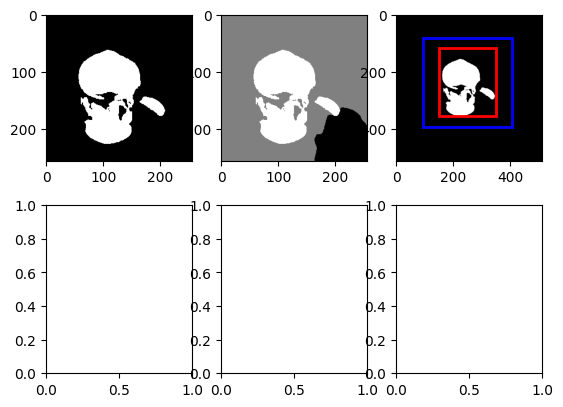

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
print(preprocessed['obj_mask_infos'][0].keys())
print(preprocessed['obj_mask_infos'][0]['crop_mask'].shape)
print(preprocessed['obj_mask_infos'][0]['target_crop_mask'].shape)
print(preprocessed['obj_mask_infos'][0]['full_mask'].shape)
print(preprocessed['obj_mask_infos'][0]['bbox'])

bbox = preprocessed['obj_mask_infos'][0]['bbox']
fig, ax = plt.subplots(2,3)

# convert to image and display
ax[0, 0].imshow(preprocessed['obj_mask_infos'][0]['crop_mask'], cmap='gray')
ax[0, 1].imshow(preprocessed['obj_mask_infos'][0]['target_crop_mask'], cmap='gray')
full_mask = preprocessed['obj_mask_infos'][0]['full_mask'].numpy()
ax[0, 2].imshow(full_mask, cmap='gray')

sq_bbox = preprocessed['obj_mask_infos'][0]['square_bbox']
# draw bbox xywh
ax[0, 2].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='r', linewidth=2))
ax[0, 2].add_patch(plt.Rectangle((sq_bbox[0], sq_bbox[1]), sq_bbox[2], sq_bbox[3], fill=False, edgecolor='b', linewidth=2))
# display(preprocessed['obj_mask_infos'][0]['crop_mask'].astype(np.uint8)*255)
# display((preprocessed['obj_mask_infos'][0]['target_crop_mask']!= 0).astype(np.uint8)*255)
# display(preprocessed['obj_mask_infos'][0]['full_mask'].numpy().astype(np.uint8)*255)

In [3]:
print(preprocessed['person_parameters'][0].keys())
print(preprocessed['person_parameters'][0]['masks'].shape)
plt.imshow(preprocessed['person_parameters'][0]['masks'][0].cpu().numpy(), cmap='gray')

dict_keys(['bboxes', 'cams', 'faces', 'local_cams', 'verts', 'verts2d', 'rotations', 'mano_pose', 'mano_pca_pose', 'mano_rot', 'mano_betas', 'mano_trans', 'translations', 'hand_side', 'masks'])
torch.Size([1, 512, 512])


NameError: name 'plt' is not defined

In [7]:
result['obj_mask_infos']


[{'bbox': tensor([ 48.6507, 225.7199,  92.7570,  80.4570]),
  'class_id': tensor(-1, device='cuda:0'),
  'full_mask': tensor([[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]),
  'score': tensor(True, device='cuda:0'),
  'square_bbox': array([ 34.73713, 205.65637, 120.58403, 120.58403], dtype=float32),
  'crop_mask': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  '

In [23]:
preprocessed['camintrs']

[array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=float32),
 array([[480.,   0., 256.],
        [  0., 480., 256.],
        [  0.,   0.,   1.]], dtype=